**Architecture **

<img src="http://drive.google.com/uc?export=view&id=12JomC2IswVbNGdE0IIvPpUk8vPjP-MBQ"  alt="artchtecture">


---



(1) Importing dependency

In [1]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten,\
                         Conv1D, MaxPooling1D
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ModelCheckpoint

import pandas as pd
import librosa
from tqdm import tqdm_notebook as tqdm
import os

import numpy as np
np.random.seed(1000)

import matplotlib.pyplot as plt
% matplotlib inline

Using TensorFlow backend.


(2) Get Data

In [2]:
base_data_path = '/data/private/SU/bbchip13/brains_on_beats/magnatagatune/'

### Make Y data
annotations_filename = base_data_path+'annotations_final_top_50_ver_1.csv'
df = pd.read_csv(annotations_filename)
y_names = df.columns[2:]
y_dict = {info[1][0]:info[1][2:].values.astype(np.int32) for info in df.iterrows()}
y_dict

{2: array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0], dtype=int32),
 6: array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
        0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0], dtype=int32),
 10: array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0], dtype=int32),
 11: array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0], dtype=int32),
 12: array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0], dtype=int32),
 14: array([0, 0, 0, 0, 0, 0, 0, 0, 0

In [3]:
def crop_random_5sec(filename):
    crop_range = 24
    offset = np.random.randint(crop_range)
    wav_5sec, sr = librosa.load(filename, offset=offset, duration=6, sr=16000)
    wav_5sec = np.expand_dims(wav_5sec, axis=1)
    return wav_5sec

def load_wavs_and_crop(filenames):
    return np.asarray([crop_random_5sec(filename) for filename in tqdm(filenames)])
    
def find_y_by_filename(filename, y_dict):
    basename = os.path.basename(filename)
    name = os.path.splitext(basename)[0]
    y = y_dict[int(name)]
    return y

def make_y_by_filenames(filenames, y_dict):
    return np.asarray([find_y_by_filename(filename, y_dict) 
                           for filename in filenames])

def make_train_data(filenames, y_dict):
    x_train = load_wavs_and_crop(filenames)
    y_train = make_y_by_filenames(filenames, y_dict)
    return x_train, y_train
    
def make_patch_data(wav, sr, i):
    patch_data = wav[i*sr:(i+6)*sr]
    patch_data = np.expand_dims(patch_data, axis=1)
    return patch_data
    
def make_patch_by_filename(filename):
    wav, sr = librosa.load(filename, sr=16000)
    patch_range = 24
    patch_list = [make_patch_data(wav, sr, i) for i in range(patch_range)]
    return np.asarray([patch_list])

def load_test_wavs(filenames):
    patch_arr = np.asarray([make_patch_by_filename(filename) for filename in tqdm(filenames)])
    result_arr = patch_arr.reshape(-1, *patch_arr.shape[-2:])
    return result_arr
#    return np.concatenate(patch_list, axis=None)

def make_test_data(filenames, y_dict):
    x_test = load_test_wavs(filenames)
    repeat_size = x_test.shape[0] / len(filenames)
    y_test = np.repeat(make_y_by_filenames(filenames, y_dict), repeat_size, axis=0)
    return x_test, y_test

In [4]:
base_mp3_path = base_data_path+'split_mp3/'
train_dir = base_mp3_path+'train/'
val_dir = base_mp3_path+'val/'
test_dir = base_mp3_path+'test/'

print('Make train data.......')
x_train_wav_filenames = [train_dir+filename for filename in os.listdir(train_dir)
                            if filename.endswith('.mp3')][:10]
x_train, y_train = make_train_data(x_train_wav_filenames, y_dict)

print('Make validation data.......')
x_val_wav_filenames = [val_dir+filename for filename in os.listdir(val_dir)
                            if filename.endswith('.mp3')][:2]
x_val, y_val = make_train_data(x_val_wav_filenames, y_dict)

print('Make test data.......')
x_test_wav_filenames = [test_dir+filename for filename in os.listdir(test_dir)
                            if filename.endswith('.mp3')][:5]
x_test, y_test = make_test_data(x_test_wav_filenames, y_dict)

print(x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape)

Make train data.......



Make validation data.......



Make test data.......



(10, 96000, 1) (10, 50) (2, 96000, 1) (2, 50) (120, 96000, 1) (120, 50)


(3) Create a sequential model

In [5]:
### Define Parametric Softplus

# alpha * log(1 + exp(beta * x))
def ParametricSoftplus(alpha=0.2, beta=5.0):
  return lambda x: alpha * keras.activations.softplus(beta * x)

In [6]:
model=Sequential()

# 1st Convolutional Layer (conv1)
model.add(Conv1D (kernel_size=121, filters=48, strides=16, padding='same',
                  input_shape=x_train.shape[1:]))
model.add(Activation(ParametricSoftplus(alpha=0.2, beta=0.5)))
model.add(BatchNormalization())

# Pooling (pool1)
model.add(MaxPooling1D(pool_size=9, strides=4, padding='same'))

# 2nd Convolutional Layer (conv2)
model.add(Conv1D (kernel_size=25, filters=128, padding='same'))
model.add(Activation(ParametricSoftplus(alpha=0.2, beta=0.5)))
model.add(BatchNormalization())

# Pooling (pool2)
model.add(MaxPooling1D(pool_size=9, strides=4, padding='same'))

# 3rd Convolutional Layer (conv3)
model.add(Conv1D (kernel_size=9, filters=192, padding='same'))
model.add(Activation(ParametricSoftplus(alpha=0.2, beta=0.5)))

# 4rd Convolutional Layer (conv4)
model.add(Conv1D (kernel_size=9, filters=192, padding='same'))
model.add(Activation(ParametricSoftplus(alpha=0.2, beta=0.5)))

# 5rd Convolutional Layer (conv5)
model.add(Conv1D (kernel_size=9, filters=128, padding='same'))
model.add(Activation(ParametricSoftplus(alpha=0.2, beta=0.5)))

# Pooling (pool5)
model.add(MaxPooling1D(pool_size=9, strides=4, padding='same'))

# 1st Dense Layer (full6)
model.add(Flatten())
model.add(Dense(4096))
model.add(Activation(ParametricSoftplus(alpha=0.2, beta=0.5)))
model.add(Dropout(0.5)) # Drop-out value is not specified in the paper

# 2nd Dense Layer (full7)
model.add(Dense(4096))
model.add(Activation(ParametricSoftplus(alpha=0.2, beta=0.5)))
model.add(Dropout(0.5))

# Output Layer (full8)
model.add(Dense(50))
model.add(Activation('sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 6000, 48)          5856      
_________________________________________________________________
activation_1 (Activation)    (None, 6000, 48)          0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 6000, 48)          192       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 1500, 48)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1500, 128)         153728    
_________________________________________________________________
activation_2 (Activation)    (None, 1500, 128)         0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 1500, 128)         512       
__________

(4) Compile 

In [7]:
adam_with_params = keras.optimizers.Adam(lr=0.0002, beta_1=0.1, beta_2=0.999, 
                                         epsilon=1e-8)


model.compile(loss='binary_crossentropy', optimizer=adam_with_params,
              metrics=['accuracy'])

(5) Train

In [8]:
model_path = 'check_point/'
os.makedirs(model_path, exist_ok=True)
model_filename = model_path+'{epoch:02d}-{val_loss:.4f}.hdf5'
checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", verbose=1, save_best_only=True)
model.fit(x_train, y_train, batch_size=36, epochs=100, validation_data=[x_val, y_val], shuffle=True, callbacks = [checkpointer])

Train on 10 samples, validate on 2 samples
Epoch 1/100
10/10 [==============================] - 5s 455ms/step - loss: 0.7016 - acc: 0.4800 - val_loss: 0.5956 - val_acc: 0.9300

Epoch 00001: val_loss improved from inf to 0.59562, saving model to check_point/01-0.5956.hdf5
Epoch 2/100
10/10 [==============================] - 0s 7ms/step - loss: 0.6083 - acc: 0.7780 - val_loss: 0.5155 - val_acc: 0.9700

Epoch 00002: val_loss improved from 0.59562 to 0.51549, saving model to check_point/02-0.5155.hdf5
Epoch 3/100
10/10 [==============================] - 0s 7ms/step - loss: 0.5334 - acc: 0.9180 - val_loss: 0.4444 - val_acc: 0.9900

Epoch 00003: val_loss improved from 0.51549 to 0.44435, saving model to check_point/03-0.4444.hdf5
Epoch 4/100
10/10 [==============================] - 0s 7ms/step - loss: 0.4615 - acc: 0.9380 - val_loss: 0.3772 - val_acc: 0.9900

Epoch 00004: val_loss improved from 0.44435 to 0.37719, saving model to check_point/04-0.3772.hdf5
Epoch 5/100
10/10 [================


Epoch 00042: val_loss did not improve from 0.10217
Epoch 43/100
10/10 [==============================] - 0s 7ms/step - loss: 0.1363 - acc: 0.9400 - val_loss: 0.1674 - val_acc: 0.9900

Epoch 00043: val_loss did not improve from 0.10217
Epoch 44/100
10/10 [==============================] - 0s 7ms/step - loss: 0.1255 - acc: 0.9500 - val_loss: 0.1768 - val_acc: 0.9800

Epoch 00044: val_loss did not improve from 0.10217
Epoch 45/100
10/10 [==============================] - 0s 7ms/step - loss: 0.1202 - acc: 0.9480 - val_loss: 0.1713 - val_acc: 0.9900

Epoch 00045: val_loss did not improve from 0.10217
Epoch 46/100
10/10 [==============================] - 0s 7ms/step - loss: 0.1245 - acc: 0.9460 - val_loss: 0.1708 - val_acc: 0.9900

Epoch 00046: val_loss did not improve from 0.10217
Epoch 47/100
10/10 [==============================] - 0s 7ms/step - loss: 0.1181 - acc: 0.9560 - val_loss: 0.2612 - val_acc: 0.9700

Epoch 00047: val_loss did not improve from 0.10217
Epoch 48/100
10/10 [========


Epoch 00087: val_loss did not improve from 0.10217
Epoch 88/100
10/10 [==============================] - 0s 7ms/step - loss: 0.0694 - acc: 0.9660 - val_loss: 0.2095 - val_acc: 0.9700

Epoch 00088: val_loss did not improve from 0.10217
Epoch 89/100
10/10 [==============================] - 0s 7ms/step - loss: 0.0801 - acc: 0.9620 - val_loss: 0.4543 - val_acc: 0.9600

Epoch 00089: val_loss did not improve from 0.10217
Epoch 90/100
10/10 [==============================] - 0s 6ms/step - loss: 0.0799 - acc: 0.9680 - val_loss: 0.2901 - val_acc: 0.9700

Epoch 00090: val_loss did not improve from 0.10217
Epoch 91/100
10/10 [==============================] - 0s 6ms/step - loss: 0.0718 - acc: 0.9700 - val_loss: 0.2689 - val_acc: 0.9800

Epoch 00091: val_loss did not improve from 0.10217
Epoch 92/100
10/10 [==============================] - 0s 6ms/step - loss: 0.0869 - acc: 0.9680 - val_loss: 0.1634 - val_acc: 0.9900

Epoch 00092: val_loss did not improve from 0.10217
Epoch 93/100
10/10 [========

In [9]:
[loss, accuracy] = model.evaluate(x_test, y_test)
print('Loss:', loss, 'Accuracy:', accuracy)

120/120 [==============================] - 0s 2ms/step
Loss: 0.8865762631098429 Accuracy: 0.9300000071525574


In [10]:
pred = model.predict(x_test)
accu_table = (pred > 0.5) & y_test
accu_arr = accu_table.sum(axis=0) / pred.shape[0]
for tag, accu in zip(y_names, accu_arr):
    print(tag, ':', accu)

no voice : 0.0
harpsichord : 0.0
sitar : 0.0
male vocal : 0.0
vocals : 0.0
beats : 0.0
classical : 0.3
female : 0.0
guitar : 0.0
quiet : 0.0
solo : 0.0
female voice : 0.0
ambient : 0.0
new age : 0.0
synth : 0.0
voice : 0.0
strings : 0.0
male voice : 0.0
loud : 0.0
classic : 0.0
drums : 0.0
electronic : 0.0
no vocal : 0.0
choral : 0.0
weird : 0.0
opera : 0.325
fast : 0.0
country : 0.0
violin : 0.03333333333333333
no vocals : 0.0
man : 0.0
harp : 0.0
pop : 0.0
female vocal : 0.0
piano : 0.0
slow : 0.0
male : 0.0
vocal : 0.0
indian : 0.0
woman : 0.0
rock : 0.0
dance : 0.0
singing : 0.0
cello : 0.0
techno : 0.0
flute : 0.0
beat : 0.0
soft : 0.0
choir : 0.0
metal : 0.0


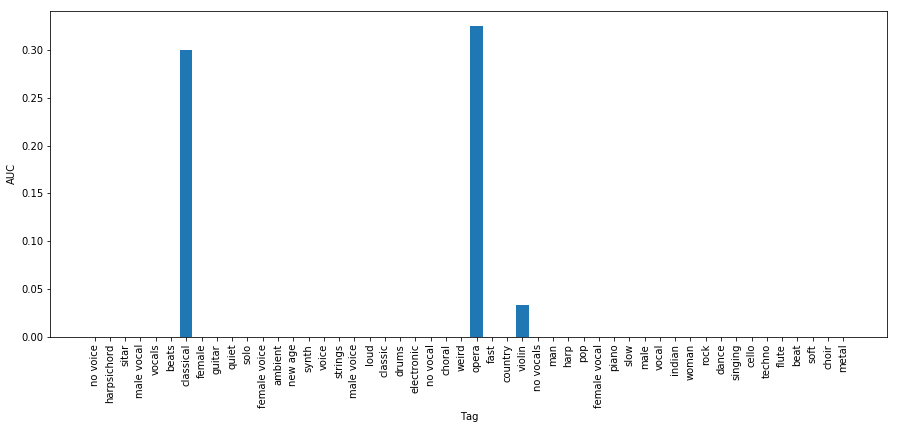

In [11]:
plt.figure(figsize = (15, 6))
x = np.arange(accu_arr.shape[0])
plt.bar(x, accu_arr)
plt.xticks(x, y_names, rotation='vertical')
plt.xlabel('Tag') # , fontsize=18)
plt.ylabel('AUC') # , fontsize=16)
# Pad margins so that markers don't get clipped by the axes
#plt.margins(0.2)
# Tweak spacing to prevent clipping of tick-labels
#plt.subplots_adjust(bottom=0.15)
#plt.legend()

plt.show()